In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
student_life_path = module_path + "/student_life"
physnet_path = module_path + "/Physionet_rev"
print(student_life_path)
print(physnet_path)

sys.path.append(physnet_path)
sys.path.append(student_life_path)

import pandas as pd
import numpy as np
import pickle
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
print(torch.cuda.is_available())
print(torch.version.cuda)

import tbm as tbm
from net_dbm import RNN_osaka


import evaluate_plot as eval_plot
import batchify as batchify
from sklearn.metrics import precision_recall_fscore_support
import importlib
import src.utils.student_utils as student_utils
import src.definitions as definitions
from IPython.display import display
importlib.reload(student_utils)

# 1 starts the process on GPU-0
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(torch.__version__)
%matplotlib inline
print(eval_plot)
print(sys.version_info)

/home/nsimsiri/MultiRes/student_life
/home/nsimsiri/MultiRes/Physionet_rev
True
9.1.85
0.4.0
<module 'evaluate_plot' from '/home/nsimsiri/MultiRes/Physionet_rev/evaluate_plot.py'>
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [2]:
device = torch.device(type='cuda')
print(torch.backends.cudnn.enabled)

True


In [3]:
x = torch.LongTensor()
print(x)
print(x.is_cuda)
y = torch.LongTensor().to(device)
# y = torch.cuda.FloatTensor()
print(y)
print(y.is_cuda)

tensor([], dtype=torch.int64)
False
tensor([], dtype=torch.int64, device='cuda:0')
True


In [4]:
import subprocess

p = subprocess.Popen(["nvcc", "--version"], stdout=subprocess.PIPE)

print(p.communicate())


(b'nvcc: NVIDIA (R) Cuda compiler driver\nCopyright (c) 2005-2017 NVIDIA Corporation\nBuilt on Fri_Nov__3_21:07:56_CDT_2017\nCuda compilation tools, release 9.1, V9.1.85\n', None)


In [5]:
data = None
pickle_path = student_life_path + '/data/training_data/student_life_pickle.pkl'
model_path = student_life_path + '/models'
print('pickle_path', pickle_path)
print('model_config_path', model_path)

pickle_path /home/nsimsiri/MultiRes/student_life/data/training_data/student_life_pickle.pkl
model_config_path /home/nsimsiri/MultiRes/student_life/models


In [6]:
with open(pickle_path, 'rb') as pickle_file:
    data = pickle.load(pickle_file)
print(data.keys())

dict_keys(['train_ids', 'val_ids', 'test_ids', 'data'])


In [7]:
params = {'bilstm_flag':True,
        'hidden_dim' : 128,
        'input_dim':128,
        'dropout' : 0.9,
        'layers' : 1,
        'tagset_size' : 5,
        'bilstm_flag' : True,
        'attn_category' : 'dot',
        'num_features' : 10,
        'batch_size':1,
        'model_name':'TBM-SL-'}

model_config_path = model_path + "/" + params['model_name']+'.pt'
print(model_config_path)
with open(model_config_path, 'wb') as config_file:
    pickle.dump(params, config_file)
    


/home/nsimsiri/MultiRes/student_life/models/TBM-SL-.pt


In [8]:
model_RNN = tbm.RNN_osaka(params).cuda()
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model_RNN.parameters(), lr=0.001, weight_decay=0.000000002)


DEVICE: cuda:0
Dot Attention is being used!


/home/nsimsiri/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [9]:
mode = 'normal'
if(mode=='normal'):
    feature_ind = 0
    label_ind = -1
    print("NORMAL mode with Flags")

NORMAL mode with Flags


In [10]:
batch_size = 1
epochs = 45
save_flag = True
dict_df_prf_mod = {}
print("==x=="*20)
print("Data Statistics")
print("Train Data: "+str(len(data['train_ids'])))
print("Val Data: "+str(len(data['val_ids'])))
print("Test Data: "+str(len(data['test_ids'])))
print("==x=="*20)

==x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x==
Data Statistics
Train Data: 17
Val Data: 5
Test Data: 7
==x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x==


  0%|          | 0/17 [00:00<?, ?it/s]

DEVICE: cuda:0
=#==#==#==#==#=0=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
/home/nsimsiri/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/nsimsiri/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


==========Epoch No:0==========
Training Loss: 27.569310784339905
Train: (0.11764705882352941, 0.11764705882352941, 0.11764705882352941, None)
             0    1         2    3    4
Precision  0.0  0.0  0.285714  0.0  0.0
Recall     0.0  0.0  0.285714  0.0  0.0
F-score    0.0  0.0  0.285714  0.0  0.0
Count      3.0  6.0  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.75, 0.2857142857142857, 0.29523809523809524, None)
              0    1         2    3    4
Precision  0.25  0.0  1.000000  0.0  0.0
Recall     1.00  0.0  0.200000  0.0  0.0
F-score    0.40  0.0  0.333333  0.0  0.0
Count      1.00  0.0  5.000000  1.0  0.0




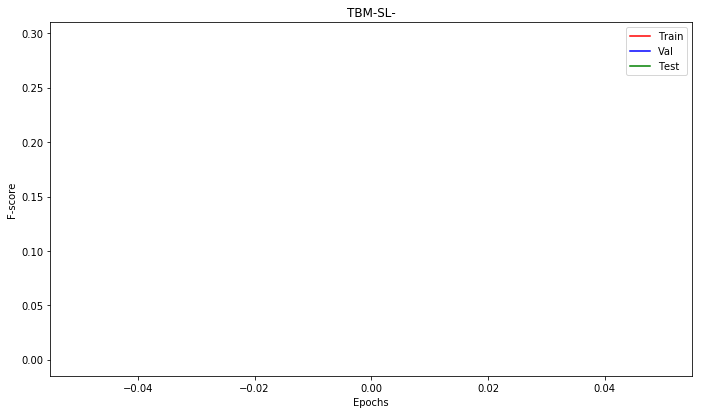

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=1=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.31it/s]


==========Epoch No:1==========
Training Loss: 25.88862442970276
Train: (0.32941176470588235, 0.35294117647058826, 0.3343137254901961, None)
                  0         1         2    3    4
Precision  0.200000  0.250000  0.500000  0.0  0.0
Recall     0.333333  0.166667  0.571429  0.0  0.0
F-score    0.250000  0.200000  0.533333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.7619047619047619, 0.42857142857142855, 0.47959183673469397, None)
                  0    1         2    3    4
Precision  0.333333  0.0  1.000000  0.0  0.0
Recall     1.000000  0.0  0.400000  0.0  0.0
F-score    0.500000  0.0  0.571429  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




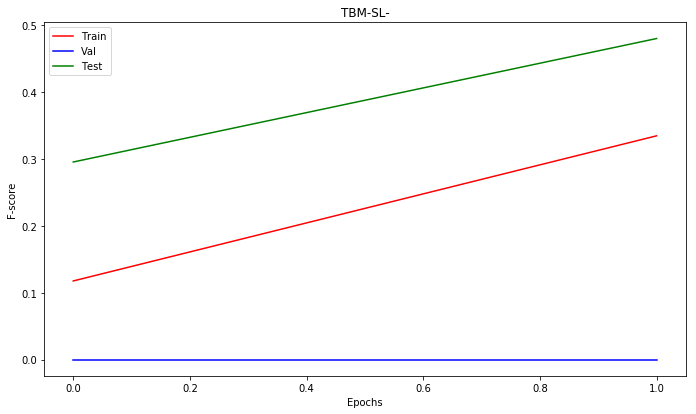

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=2=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.39it/s]


==========Epoch No:2==========
Training Loss: 24.871376514434814
Train: (0.46405228758169936, 0.47058823529411764, 0.4240196078431373, None)
                  0         1         2    3    4
Precision  0.333333  0.500000  0.555556  0.0  0.0
Recall     0.666667  0.166667  0.714286  0.0  0.0
F-score    0.444444  0.250000  0.625000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.7619047619047619, 0.42857142857142855, 0.47959183673469397, None)
                  0    1         2    3    4
Precision  0.333333  0.0  1.000000  0.0  0.0
Recall     1.000000  0.0  0.400000  0.0  0.0
F-score    0.500000  0.0  0.571429  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




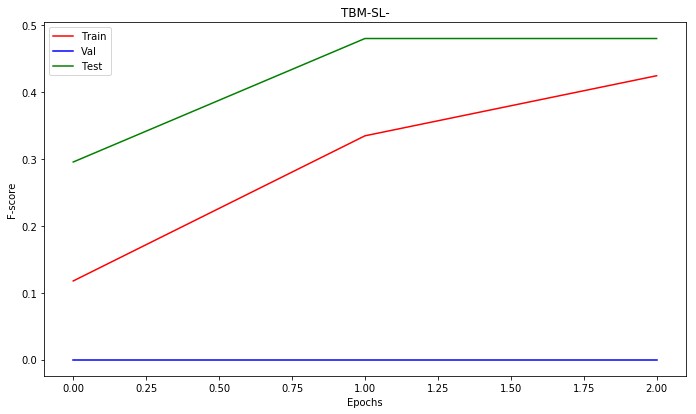

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=3=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.37it/s]


==========Epoch No:3==========
Training Loss: 23.955513954162598
Train: (0.48424369747899165, 0.47058823529411764, 0.4333333333333333, None)
                  0         1         2    3    4
Precision  0.285714  0.500000  0.625000  0.0  0.0
Recall     0.666667  0.166667  0.714286  0.0  0.0
F-score    0.400000  0.250000  0.666667  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.7619047619047619, 0.42857142857142855, 0.47959183673469397, None)
                  0    1         2    3    4
Precision  0.333333  0.0  1.000000  0.0  0.0
Recall     1.000000  0.0  0.400000  0.0  0.0
F-score    0.500000  0.0  0.571429  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




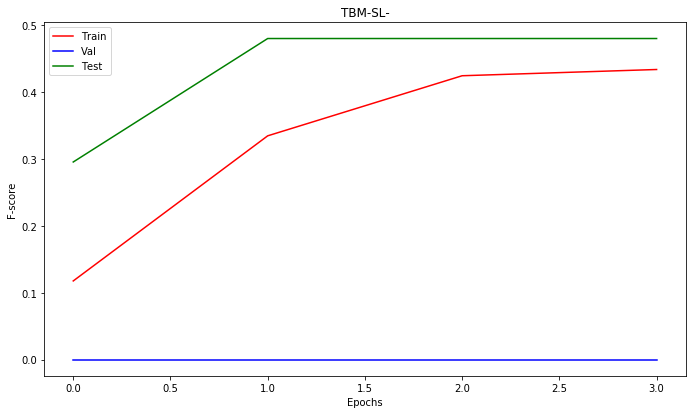

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=4=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.39it/s]


==========Epoch No:4==========
Training Loss: 23.25163507461548
Train: (0.5784313725490197, 0.5294117647058824, 0.49321266968325783, None)
                  0         1         2    3    4
Precision  0.333333  0.500000  0.833333  0.0  0.0
Recall     1.000000  0.166667  0.714286  0.0  0.0
F-score    0.500000  0.250000  0.769231  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.5238095238095238, 0.42857142857142855, 0.42857142857142855, None)
                  0    1         2    3    4
Precision  0.333333  0.0  0.666667  0.0  0.0
Recall     1.000000  0.0  0.400000  0.0  0.0
F-score    0.500000  0.0  0.500000  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




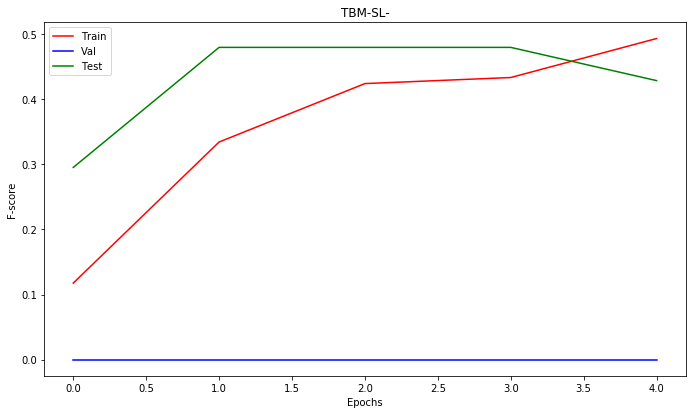

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=5=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.37it/s]


==========Epoch No:5==========
Training Loss: 22.413680493831635
Train: (0.7373949579831932, 0.6470588235294118, 0.6117647058823529, None)
                  0         1         2    3    4
Precision  0.428571  1.000000  0.750000  0.0  0.0
Recall     1.000000  0.333333  0.857143  0.0  0.0
F-score    0.600000  0.500000  0.800000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.6071428571428571, 0.5714285714285714, 0.5714285714285713, None)
                  0    1         2    3    4
Precision  0.500000  0.0  0.750000  0.0  0.0
Recall     1.000000  0.0  0.600000  0.0  0.0
F-score    0.666667  0.0  0.666667  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




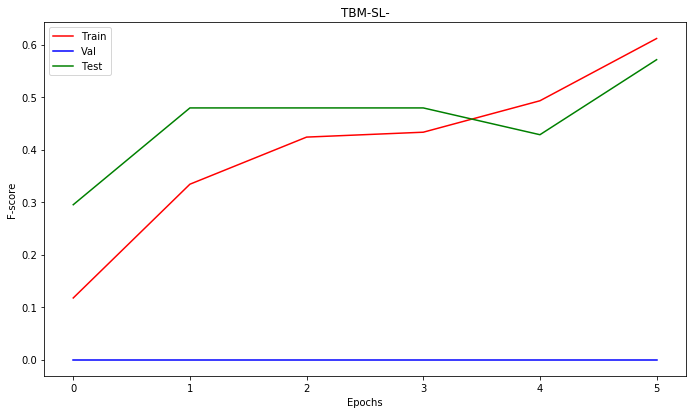

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=6=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.43it/s]


==========Epoch No:6==========
Training Loss: 21.626911163330078
Train: (0.7720588235294118, 0.8235294117647058, 0.796078431372549, None)
                  0         1         2    3    4
Precision  0.666667  0.833333  0.875000  0.0  0.0
Recall     0.666667  0.833333  1.000000  0.0  0.0
F-score    0.666667  0.833333  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.6071428571428571, 0.5714285714285714, 0.5714285714285713, None)
                  0    1         2    3    4
Precision  0.500000  0.0  0.750000  0.0  0.0
Recall     1.000000  0.0  0.600000  0.0  0.0
F-score    0.666667  0.0  0.666667  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




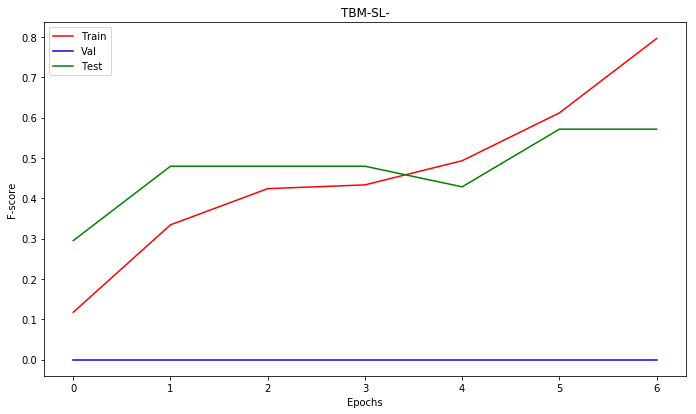

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=7=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


==========Epoch No:7==========
Training Loss: 21.113948106765747
Train: (0.7026143790849674, 0.7647058823529411, 0.7250000000000001, None)
                  0         1         2    3    4
Precision  0.500000  0.833333  0.777778  0.0  0.0
Recall     0.333333  0.833333  1.000000  0.0  0.0
F-score    0.400000  0.833333  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.6071428571428571, 0.5714285714285714, 0.5714285714285713, None)
                  0    1         2    3    4
Precision  0.500000  0.0  0.750000  0.0  0.0
Recall     1.000000  0.0  0.600000  0.0  0.0
F-score    0.666667  0.0  0.666667  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




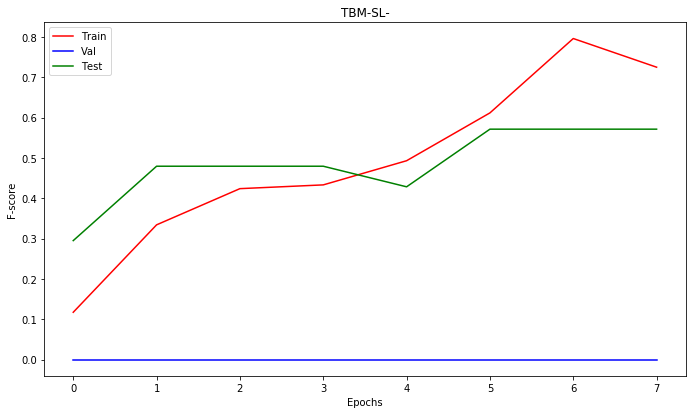

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=8=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


==========Epoch No:8==========
Training Loss: 20.662785410881042
Train: (0.7026143790849674, 0.7647058823529411, 0.7250000000000001, None)
                  0         1         2    3    4
Precision  0.500000  0.833333  0.777778  0.0  0.0
Recall     0.333333  0.833333  1.000000  0.0  0.0
F-score    0.400000  0.833333  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.6071428571428571, 0.5714285714285714, 0.5714285714285713, None)
                  0    1         2    3    4
Precision  0.500000  0.0  0.750000  0.0  0.0
Recall     1.000000  0.0  0.600000  0.0  0.0
F-score    0.666667  0.0  0.666667  0.0  0.0
Count      1.000000  0.0  5.000000  1.0  0.0




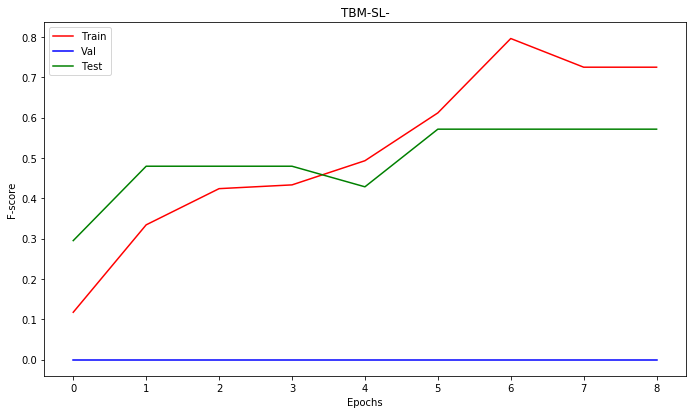

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=9=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


==========Epoch No:9==========
Training Loss: 20.19420349597931
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




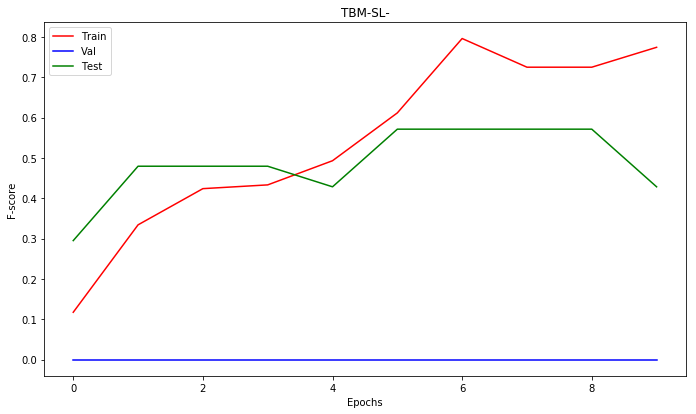

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=10=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.51it/s]


==========Epoch No:10==========
Training Loss: 19.76724022626877
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




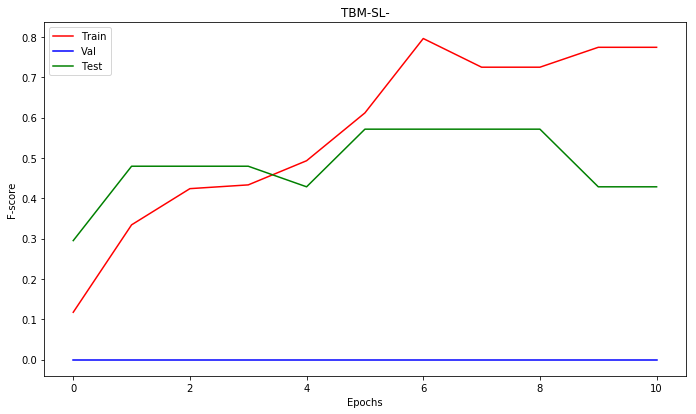

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=11=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


==========Epoch No:11==========
Training Loss: 19.36943870782852
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




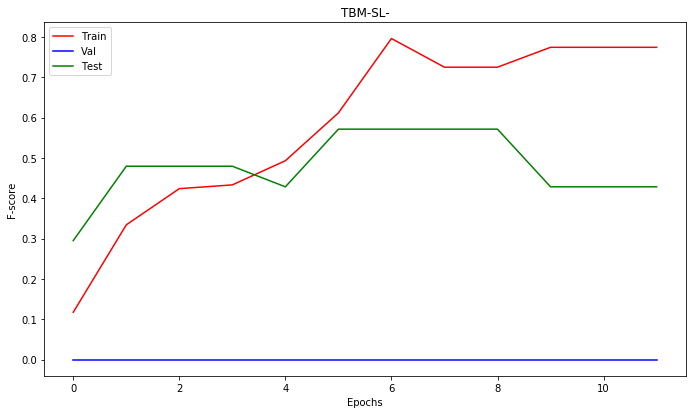

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=12=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


==========Epoch No:12==========
Training Loss: 18.888858020305634
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




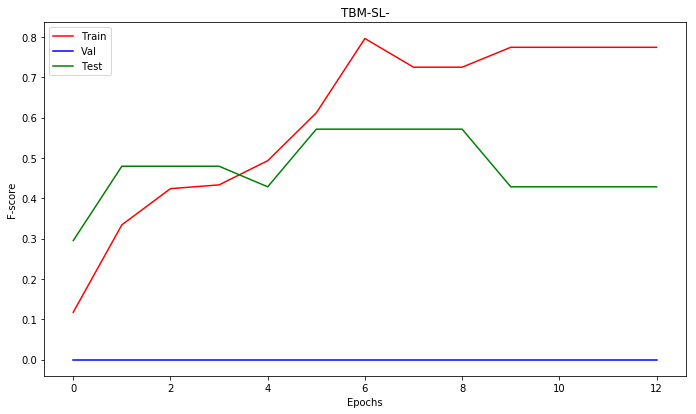

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=13=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.43it/s]


==========Epoch No:13==========
Training Loss: 18.439510583877563
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




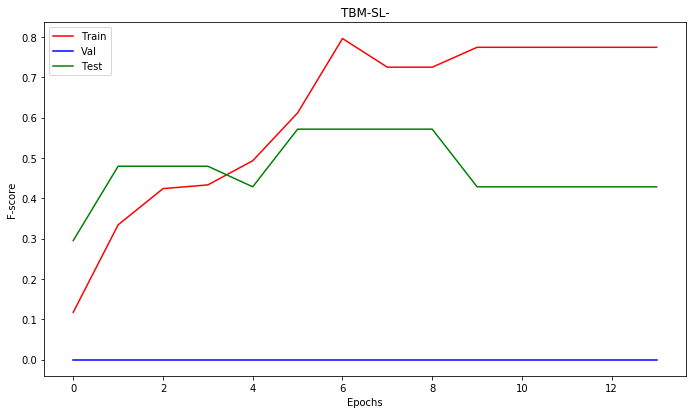

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=14=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


==========Epoch No:14==========
Training Loss: 18.17592054605484
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




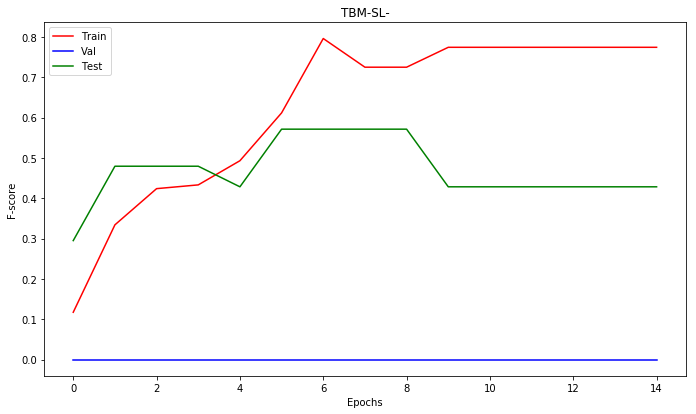

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=15=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.47it/s]


==========Epoch No:15==========
Training Loss: 17.784065186977386
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




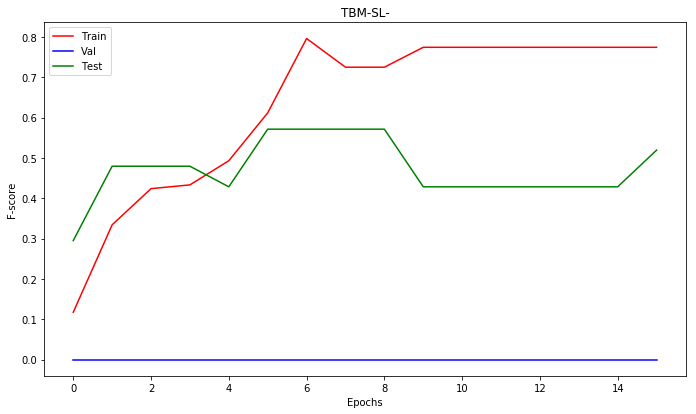

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=16=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.21it/s]


==========Epoch No:16==========
Training Loss: 17.454504549503326
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




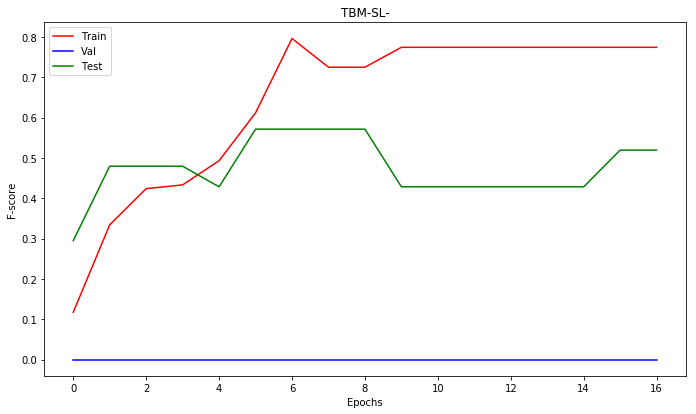

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=17=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


==========Epoch No:17==========
Training Loss: 17.17171961069107
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




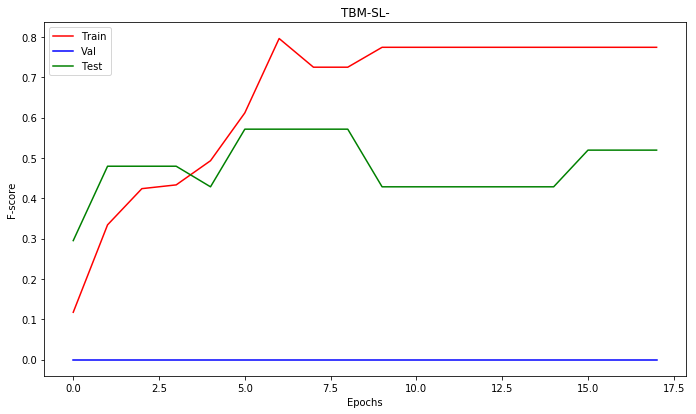

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=18=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.38it/s]


==========Epoch No:18==========
Training Loss: 16.886906325817108
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




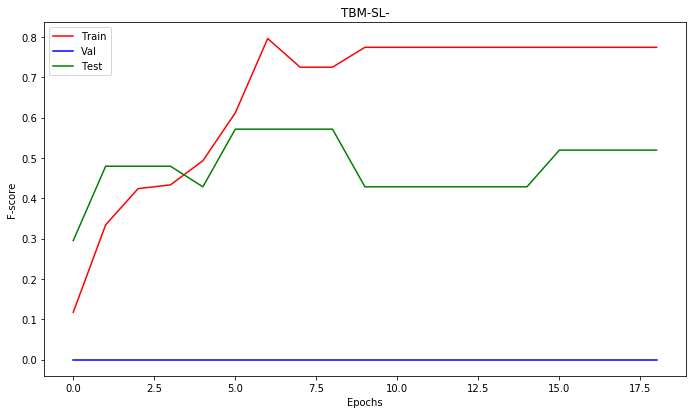

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=19=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.30it/s]


==========Epoch No:19==========
Training Loss: 16.588232100009918
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




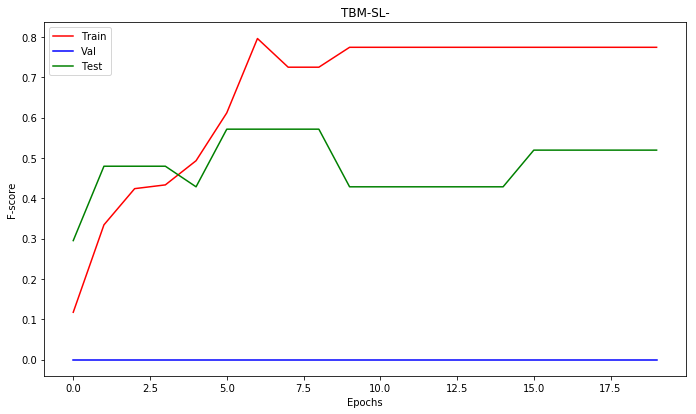

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=20=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


==========Epoch No:20==========
Training Loss: 16.355861127376556
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




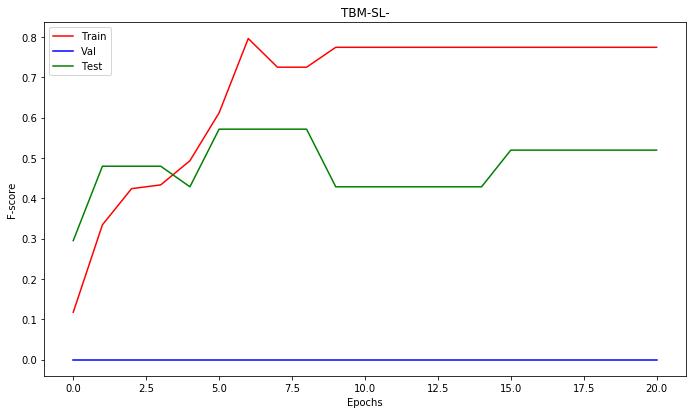

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=21=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


==========Epoch No:21==========
Training Loss: 16.13964545726776
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




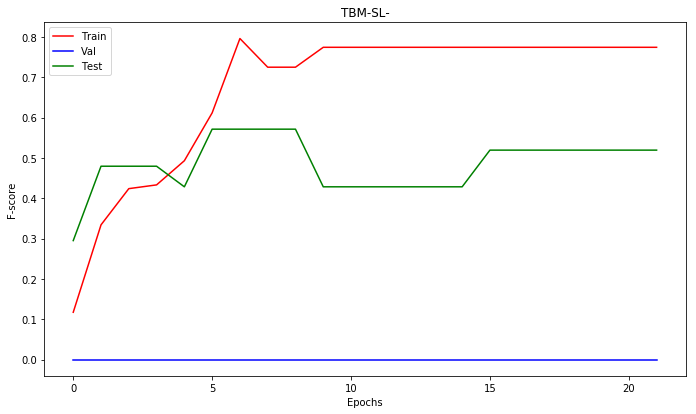

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=22=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.36it/s]


==========Epoch No:22==========
Training Loss: 15.932045698165894
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




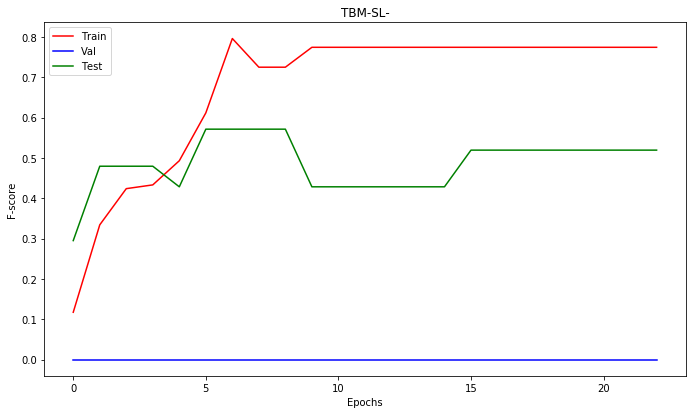

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=23=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.27it/s]


==========Epoch No:23==========
Training Loss: 15.726922929286957
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




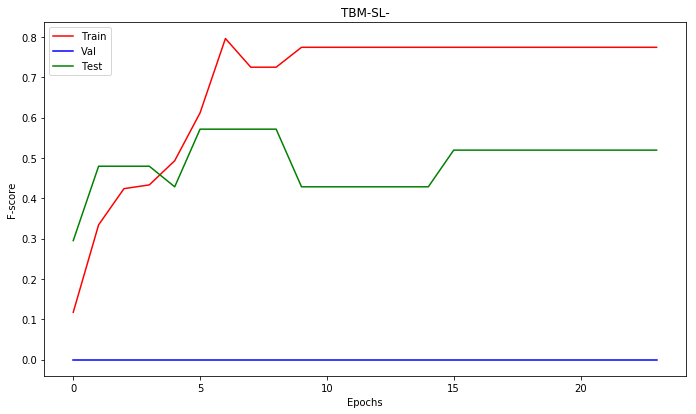

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=24=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


==========Epoch No:24==========
Training Loss: 15.460174858570099
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




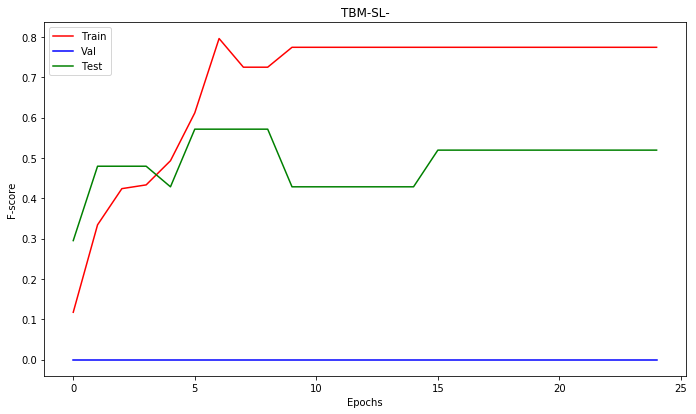

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=25=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


==========Epoch No:25==========
Training Loss: 15.266480207443237
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




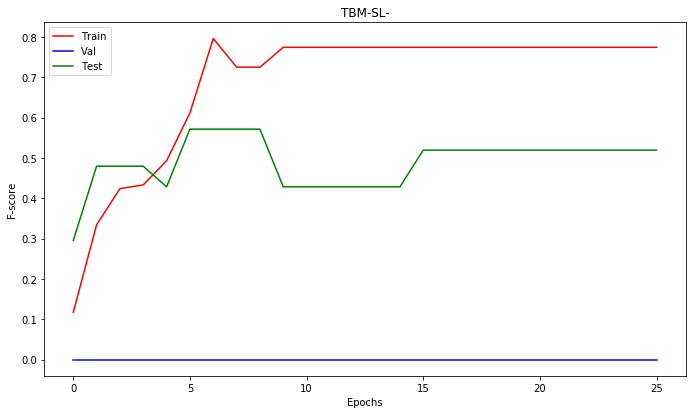

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=26=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.42it/s]


==========Epoch No:26==========
Training Loss: 15.07531875371933
Train: (0.7992530345471521, 0.8235294117647058, 0.7743212669683259, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.777778  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.923077  0.875000  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.47619047619047616, 0.5714285714285714, 0.5194805194805194, None)
             0    1         2    3    4
Precision  0.0  0.0  0.666667  0.0  0.0
Recall     0.0  0.0  0.800000  0.0  0.0
F-score    0.0  0.0  0.727273  0.0  0.0
Count      1.0  0.0  5.000000  1.0  0.0




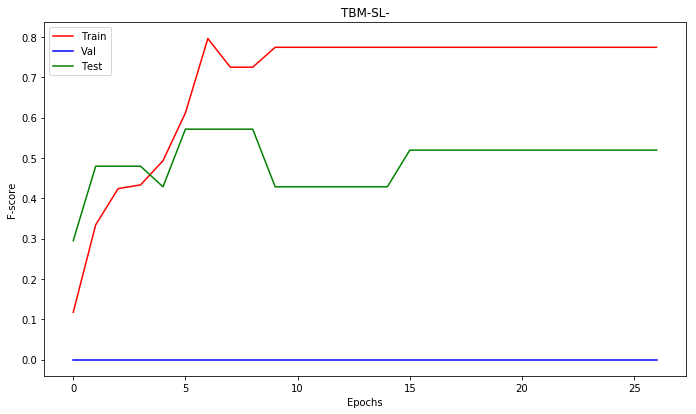

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=27=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


==========Epoch No:27==========
Training Loss: 14.782490253448486
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




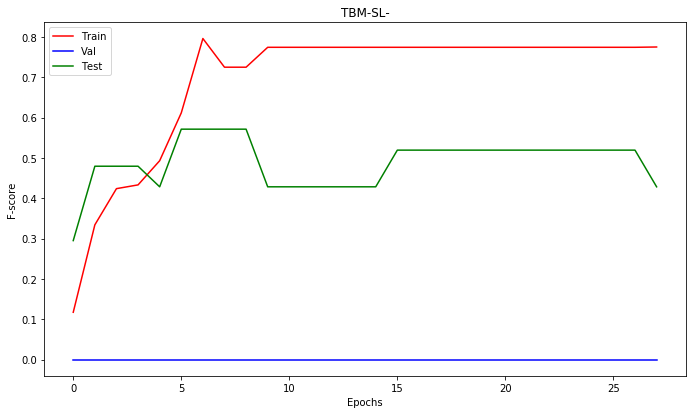

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=28=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


==========Epoch No:28==========
Training Loss: 14.58067125082016
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




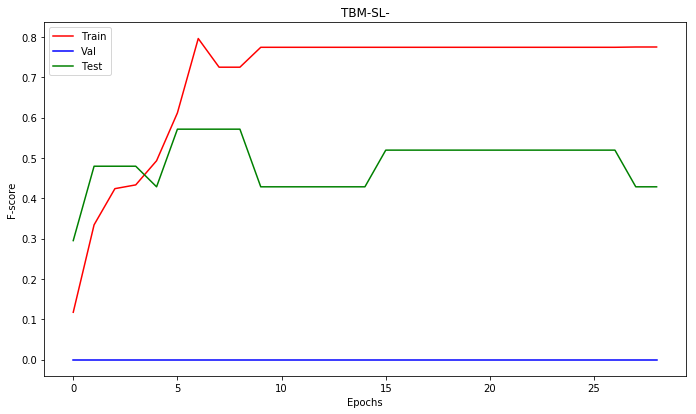

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=29=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.37it/s]


==========Epoch No:29==========
Training Loss: 14.392228484153748
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




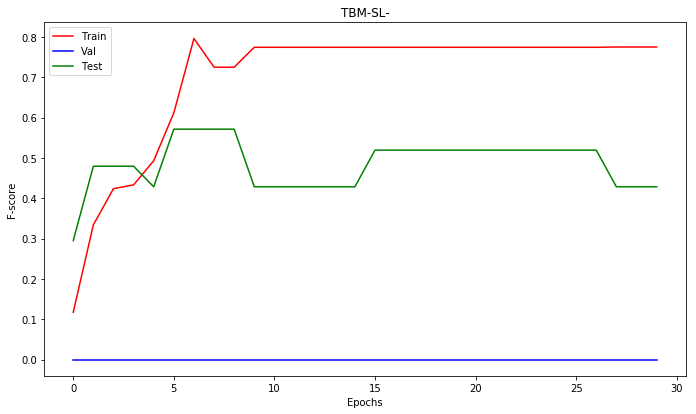

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=30=#==#==#==#==#=


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


==========Epoch No:30==========
Training Loss: 14.222464978694916
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




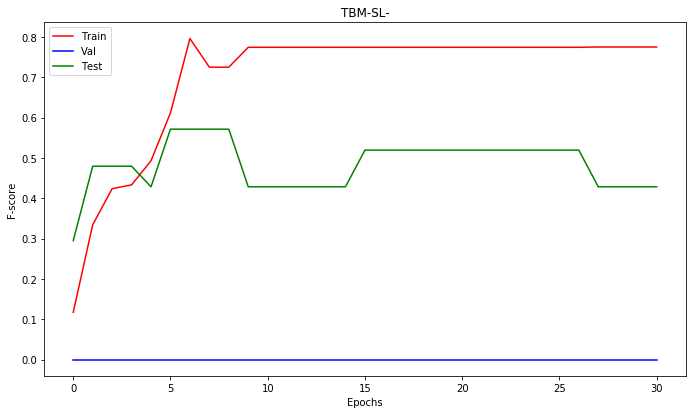

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=31=#==#==#==#==#=


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


==========Epoch No:31==========
Training Loss: 14.058341801166534
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




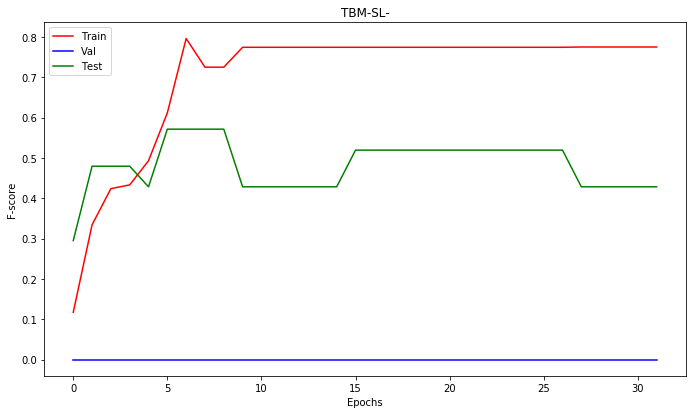

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=32=#==#==#==#==#=


100%|██████████| 17/17 [00:05<00:00,  3.51it/s]


==========Epoch No:32==========
Training Loss: 13.896140813827515
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




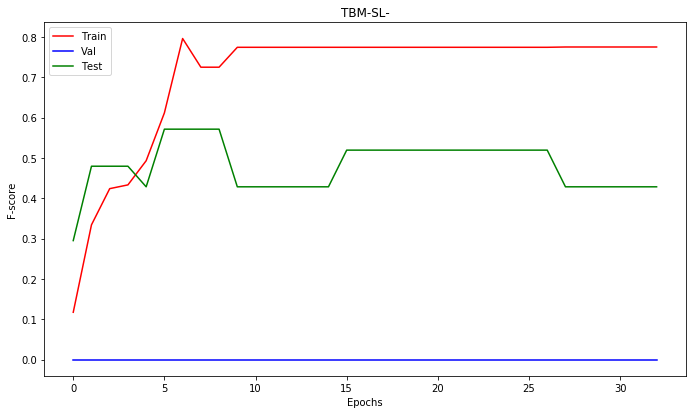

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=33=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


==========Epoch No:33==========
Training Loss: 13.744601905345917
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




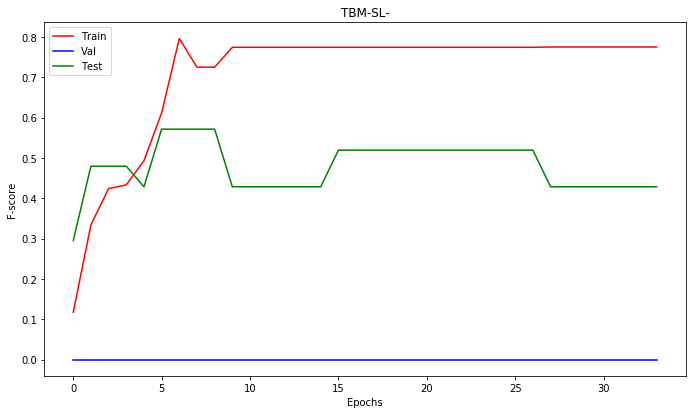

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=34=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


==========Epoch No:34==========
Training Loss: 13.593808233737946
Train: (0.8014705882352942, 0.8235294117647058, 0.7750700280112044, None)
                  0         1         2    3    4
Precision  1.000000  0.750000  0.875000  0.0  0.0
Recall     0.333333  1.000000  1.000000  0.0  0.0
F-score    0.500000  0.857143  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




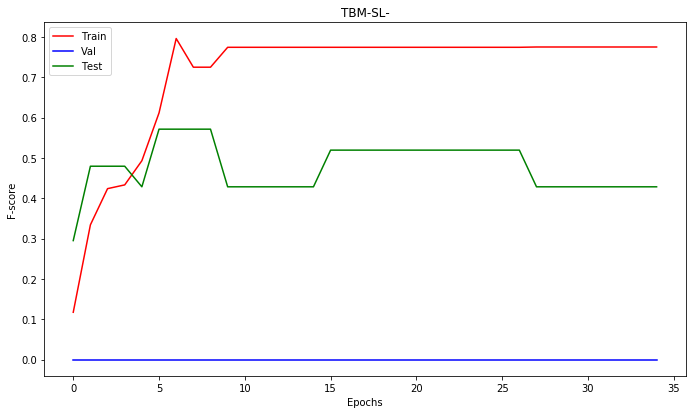

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=35=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.64it/s]


==========Epoch No:35==========
Training Loss: 13.444940865039825
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




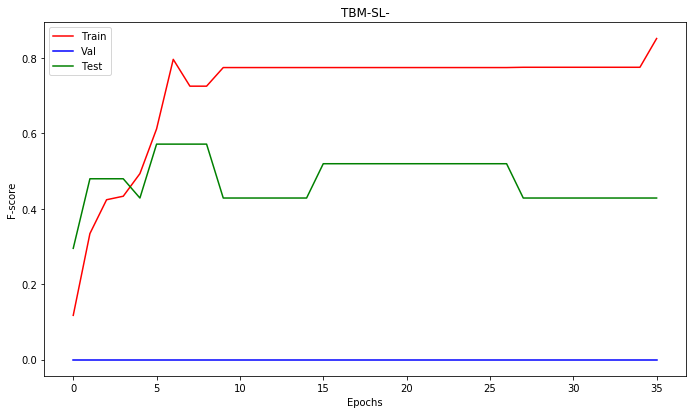

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=36=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


==========Epoch No:36==========
Training Loss: 13.285640060901642
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




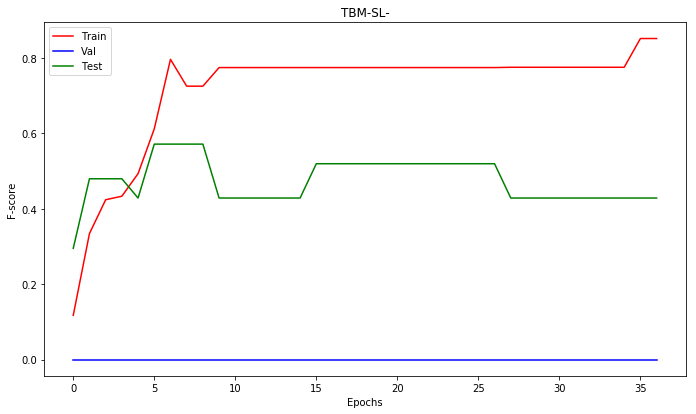

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=37=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.38it/s]


==========Epoch No:37==========
Training Loss: 13.130046248435974
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




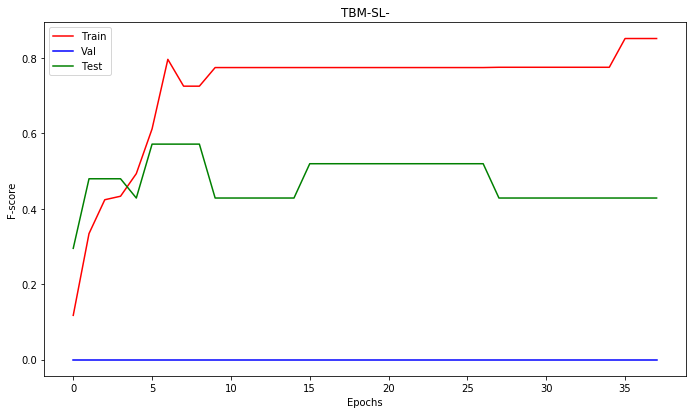

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=38=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.65it/s]


==========Epoch No:38==========
Training Loss: 12.989056169986725
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




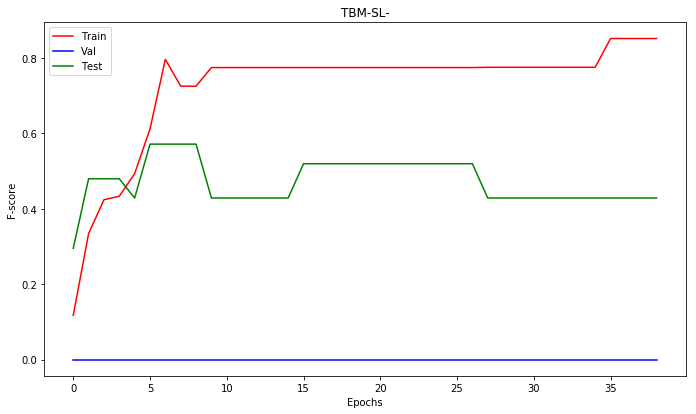

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=39=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.64it/s]


==========Epoch No:39==========
Training Loss: 12.859531998634338
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




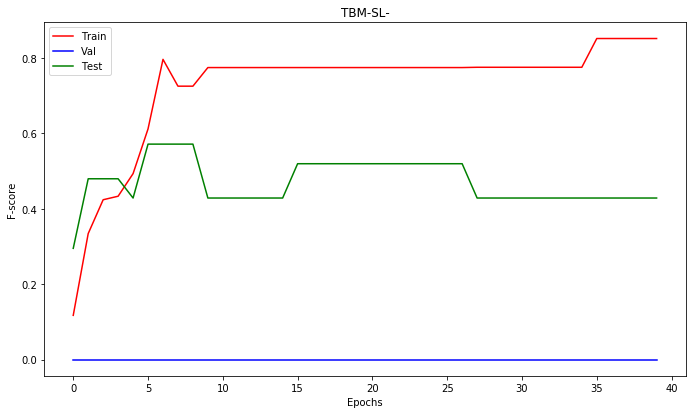

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=40=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


==========Epoch No:40==========
Training Loss: 12.737722277641296
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




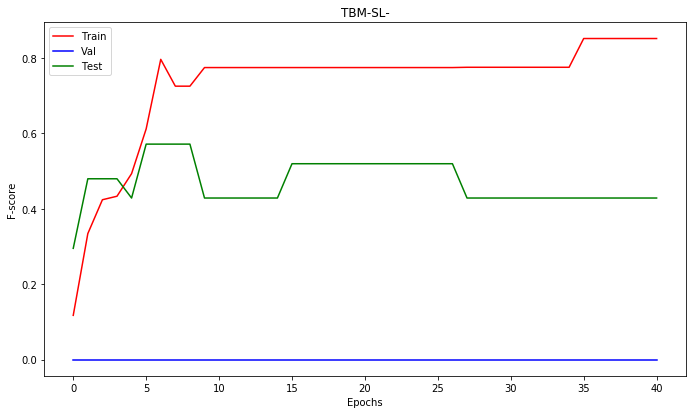

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=41=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.65it/s]


==========Epoch No:41==========
Training Loss: 12.620981097221375
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




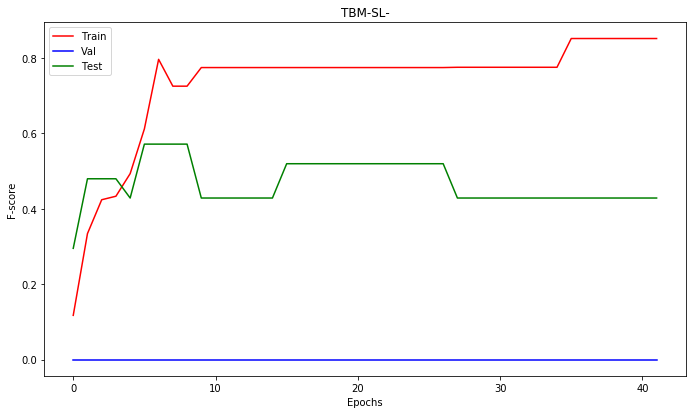

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=42=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


==========Epoch No:42==========
Training Loss: 12.507697820663452
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




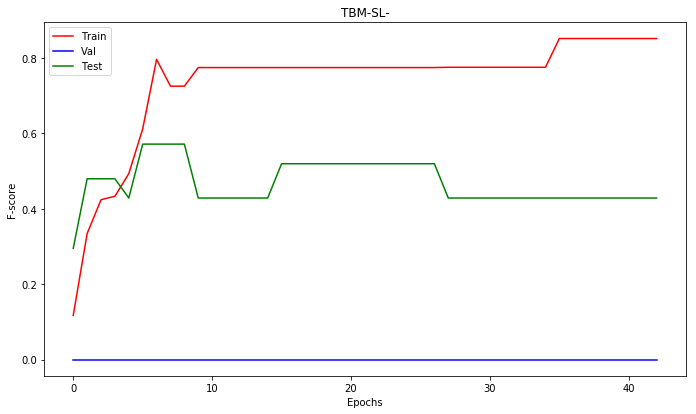

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=43=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


==========Epoch No:43==========
Training Loss: 12.396816492080688
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




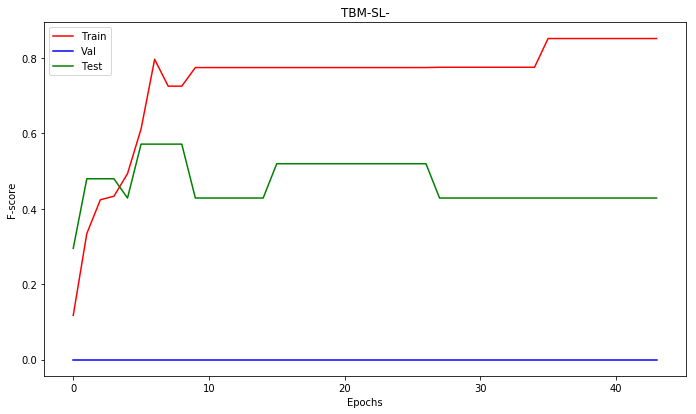

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=44=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.39it/s]


==========Epoch No:44==========
Training Loss: 12.270698487758636
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




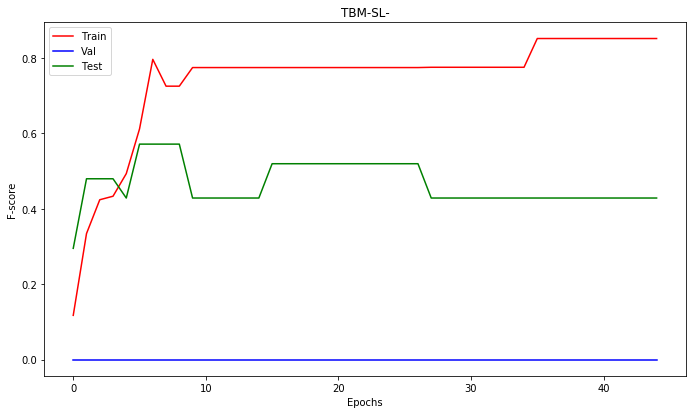

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=45=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


==========Epoch No:45==========
Training Loss: 12.15279096364975
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




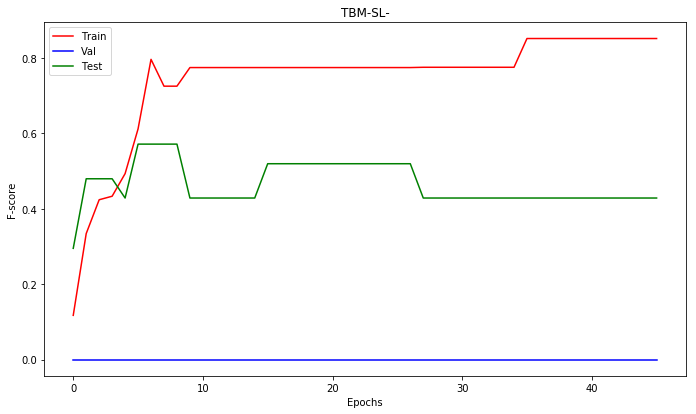

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=46=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


==========Epoch No:46==========
Training Loss: 12.048622727394104
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




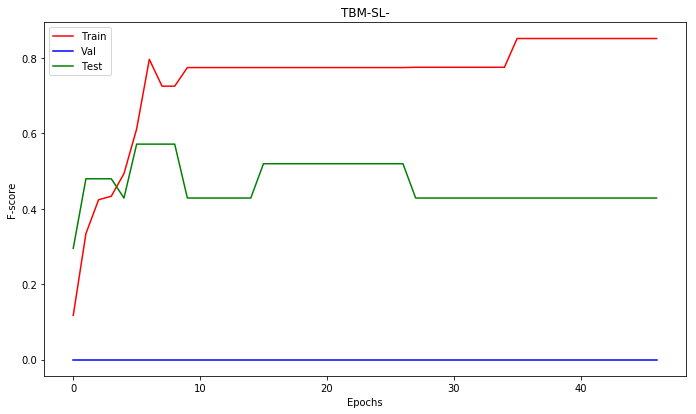

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=47=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


==========Epoch No:47==========
Training Loss: 11.946211576461792
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




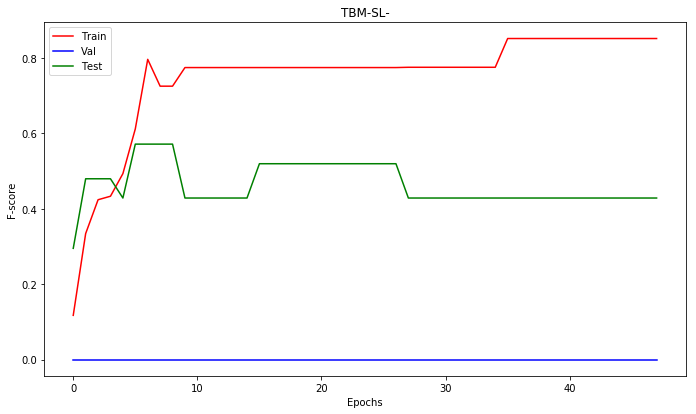

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=48=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.65it/s]


==========Epoch No:48==========
Training Loss: 12.21781837940216
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




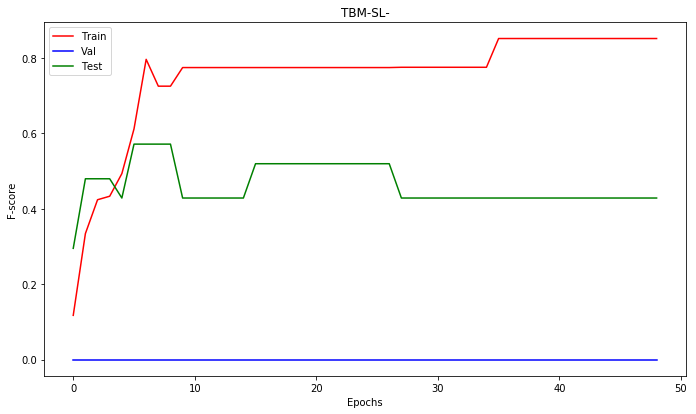

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=49=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


==========Epoch No:49==========
Training Loss: 12.098135948181152
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




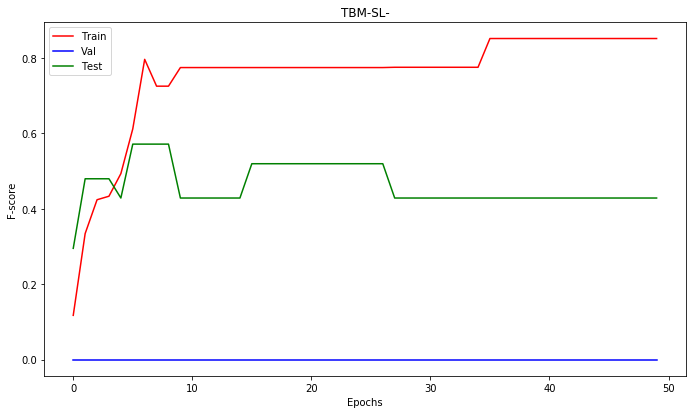

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=50=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


==========Epoch No:50==========
Training Loss: 11.990587174892426
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




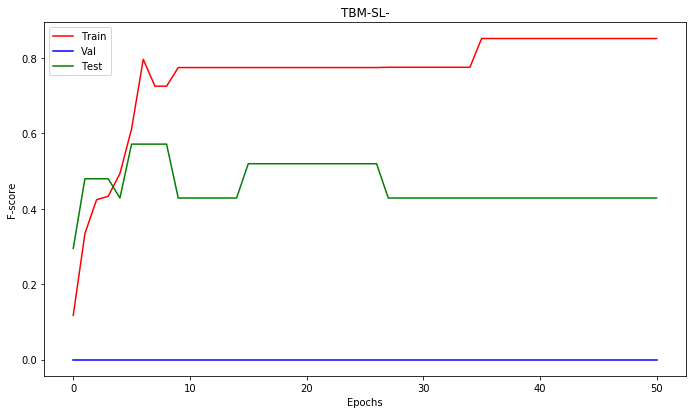

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=51=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


==========Epoch No:51==========
Training Loss: 11.891438007354736
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




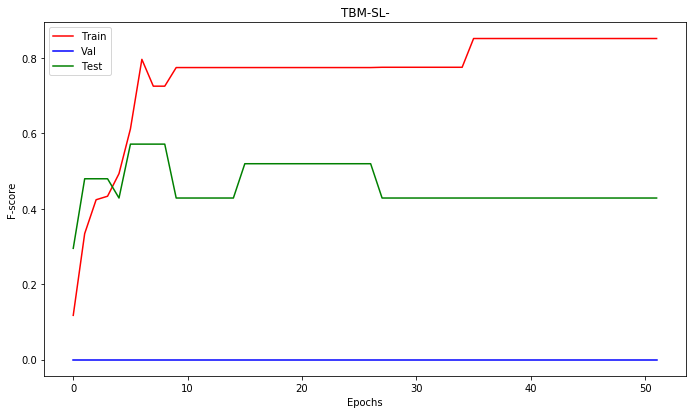

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=52=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  4.12it/s]


==========Epoch No:52==========
Training Loss: 11.79206758737564
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




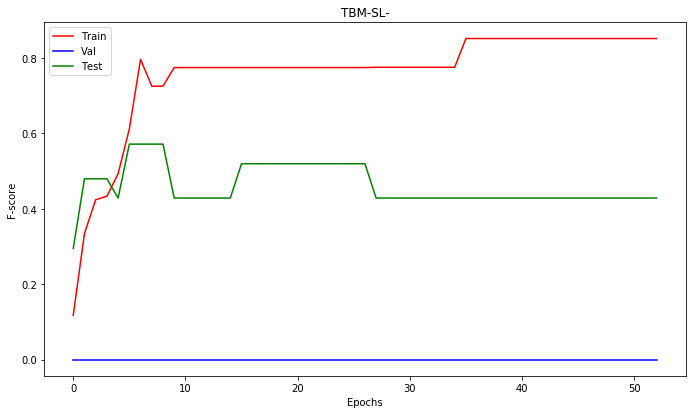

  6%|▌         | 1/17 [00:00<00:03,  5.03it/s]

=#==#==#==#==#=53=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.86it/s]


==========Epoch No:53==========
Training Loss: 11.681537568569183
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




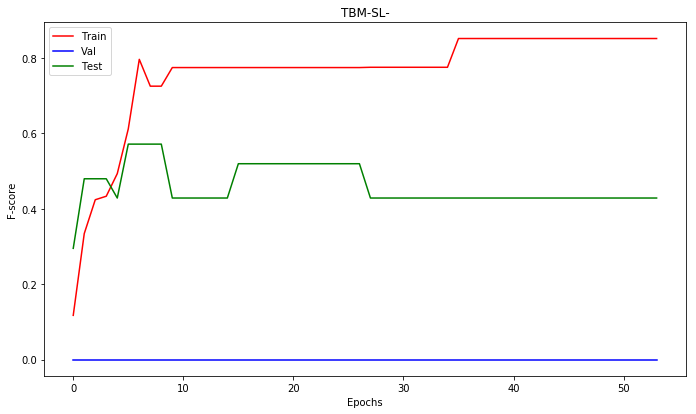

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=54=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.71it/s]


==========Epoch No:54==========
Training Loss: 11.531738221645355
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




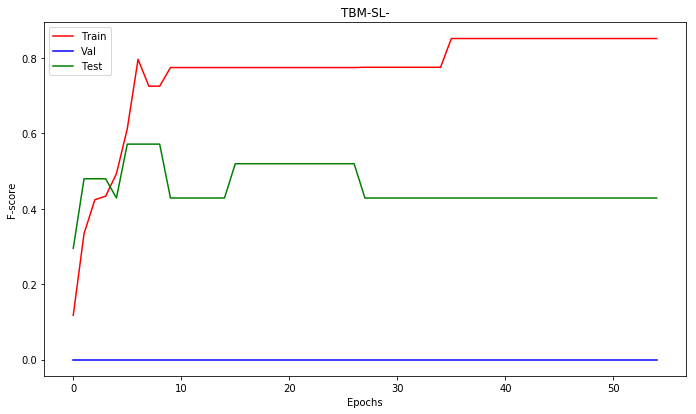

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=55=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


==========Epoch No:55==========
Training Loss: 11.433537364006042
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




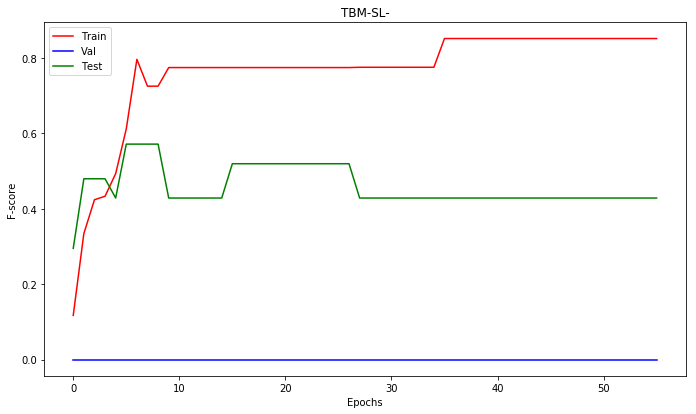

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=56=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


==========Epoch No:56==========
Training Loss: 11.333057463169098
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




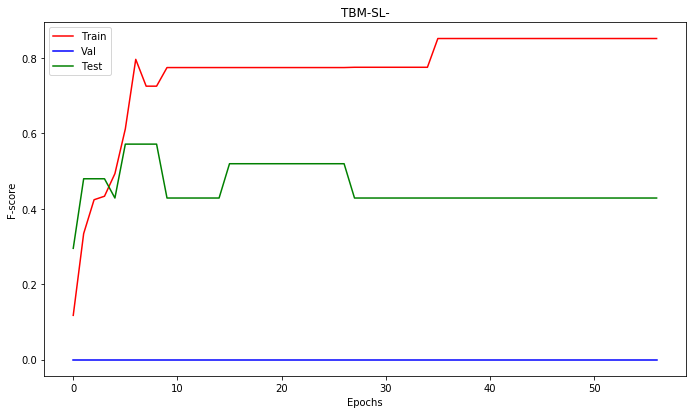

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=57=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


==========Epoch No:57==========
Training Loss: 11.240142345428467
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




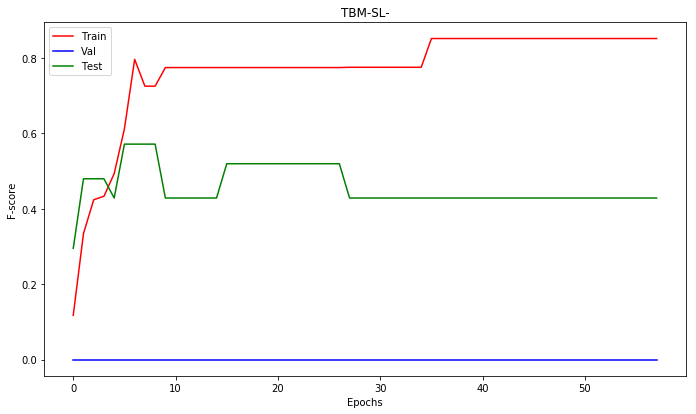

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=58=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.25it/s]


==========Epoch No:58==========
Training Loss: 11.144408166408539
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




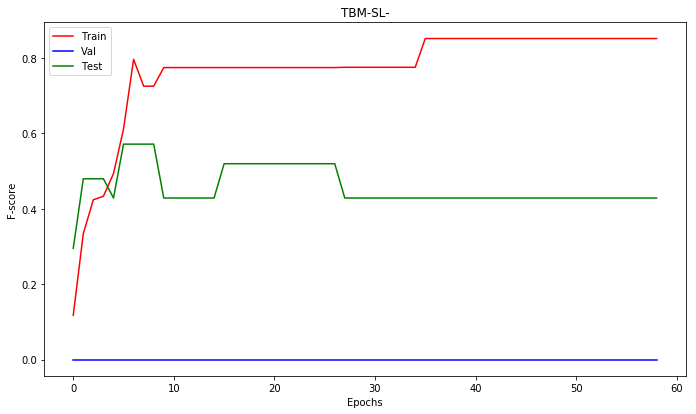

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=59=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


==========Epoch No:59==========
Training Loss: 11.186277627944946
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




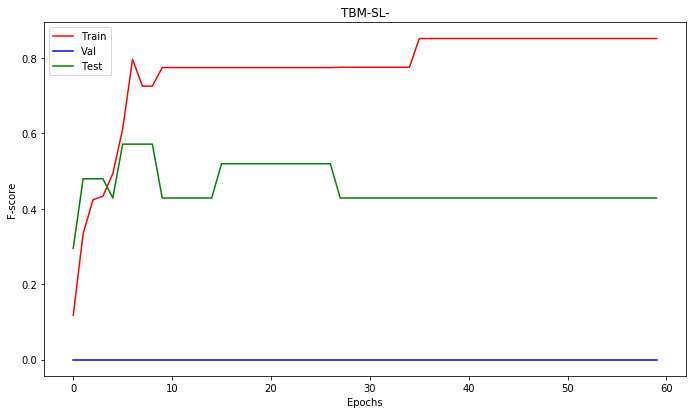

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=60=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


==========Epoch No:60==========
Training Loss: 11.071241855621338
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




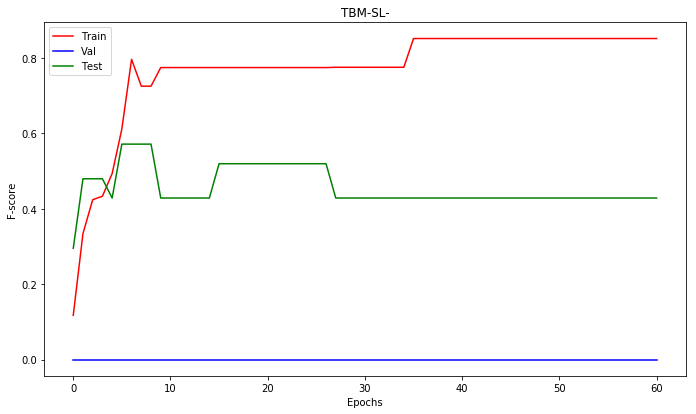

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=61=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


==========Epoch No:61==========
Training Loss: 10.983400344848633
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




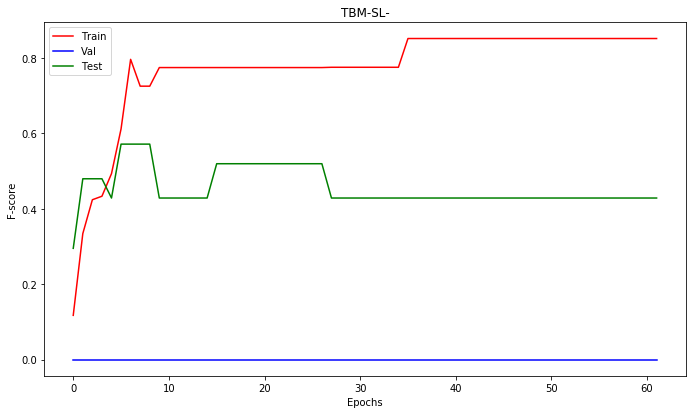

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=62=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


==========Epoch No:62==========
Training Loss: 10.904120028018951
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




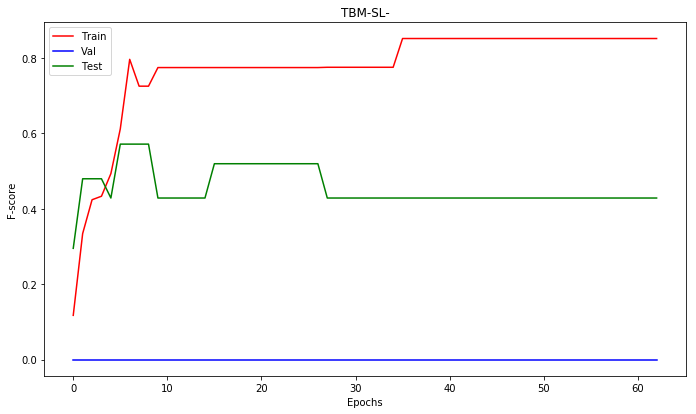

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=63=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


==========Epoch No:63==========
Training Loss: 10.825918018817902
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




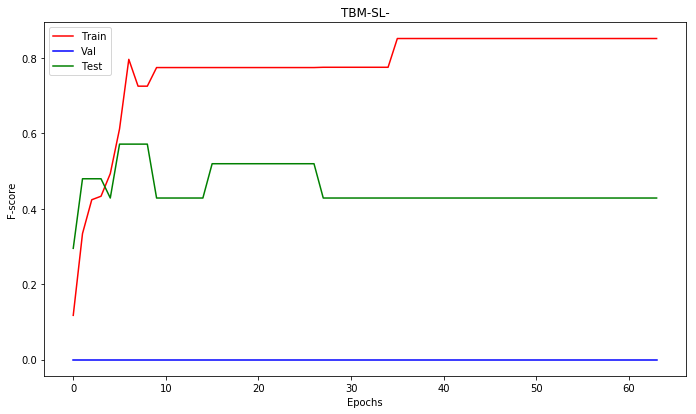

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=64=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


==========Epoch No:64==========
Training Loss: 10.750614047050476
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




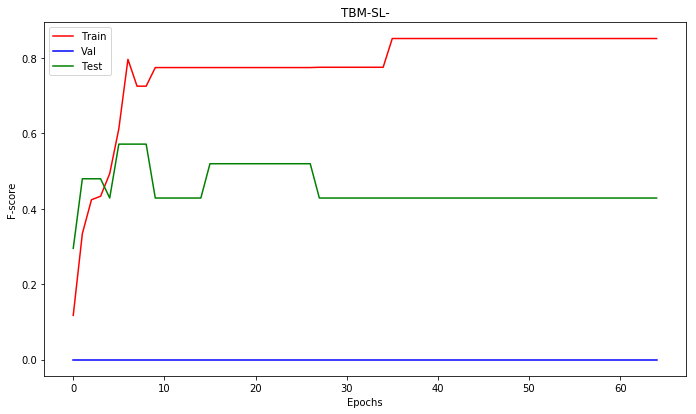

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=65=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.38it/s]


==========Epoch No:65==========
Training Loss: 10.677786707878113
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




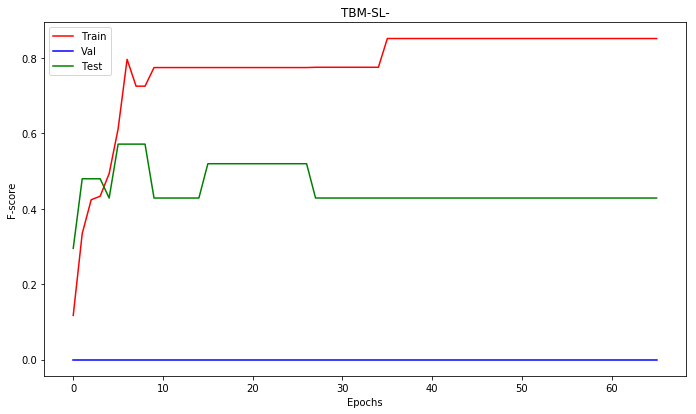

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=66=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


==========Epoch No:66==========
Training Loss: 10.736532092094421
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




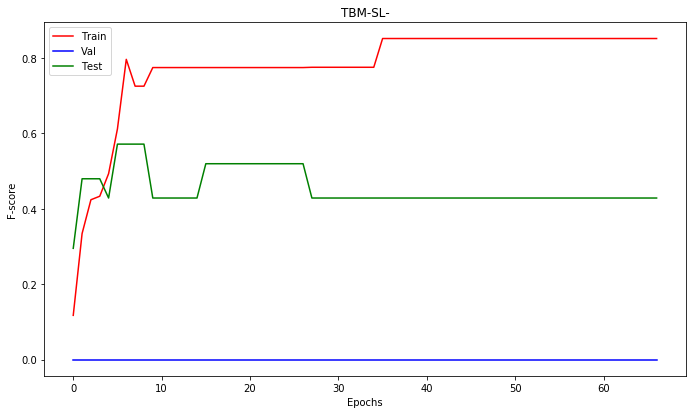

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=67=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


==========Epoch No:67==========
Training Loss: 10.80036199092865
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




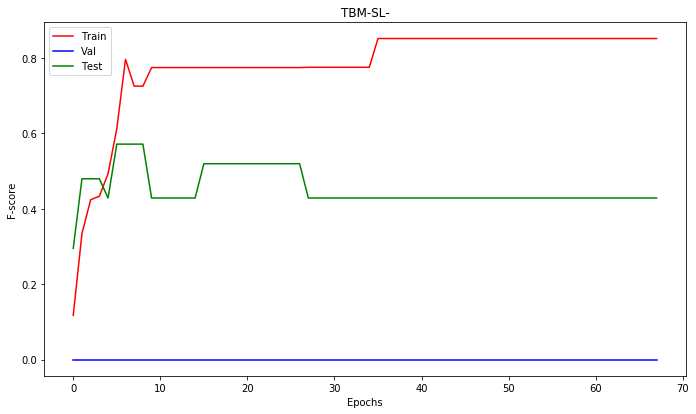

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=68=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


==========Epoch No:68==========
Training Loss: 10.718182802200317
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




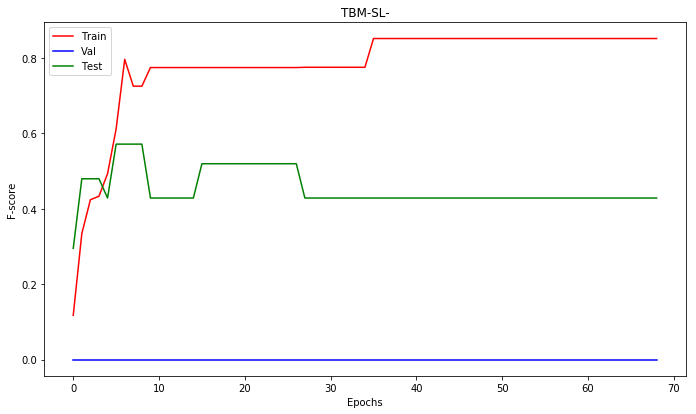

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=69=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


==========Epoch No:69==========
Training Loss: 10.623524010181427
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




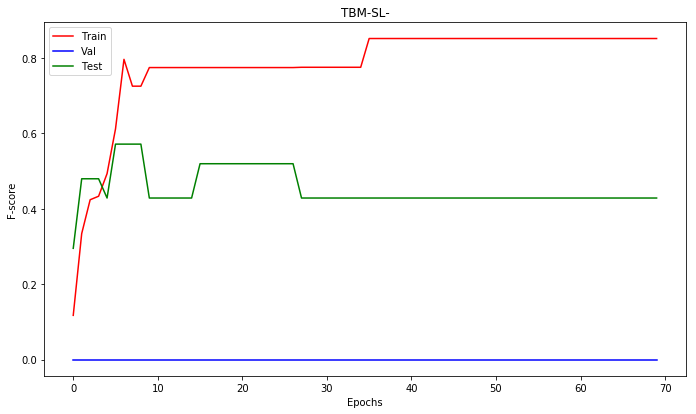

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=70=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


==========Epoch No:70==========
Training Loss: 10.536281108856201
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




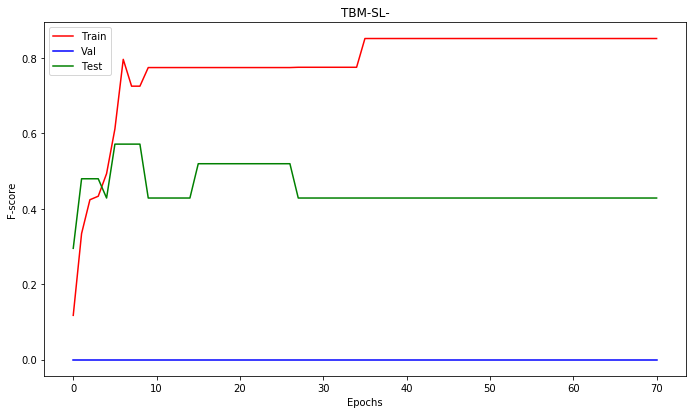

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=71=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


==========Epoch No:71==========
Training Loss: 10.392333745956421
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




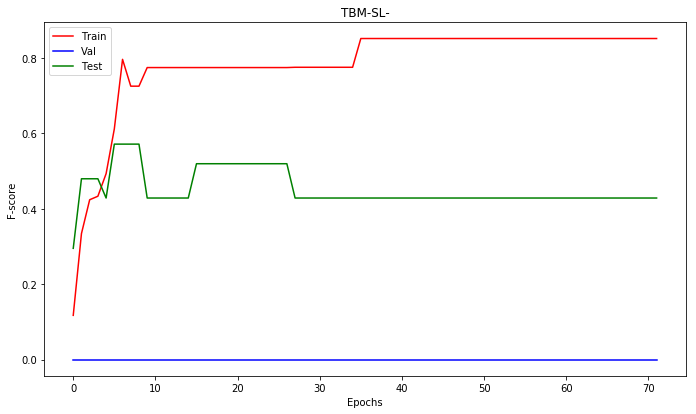

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=72=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


==========Epoch No:72==========
Training Loss: 10.34876012802124
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




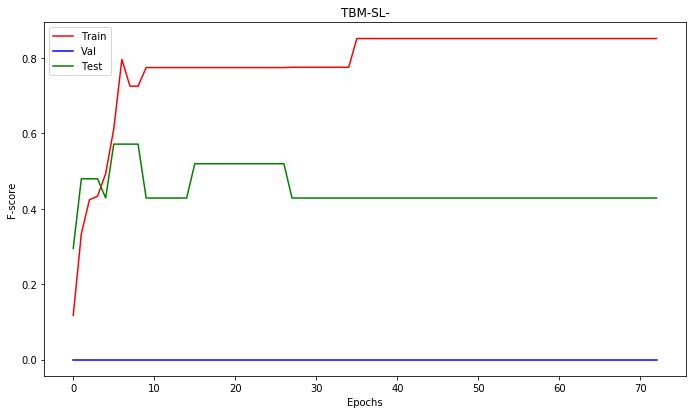

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=73=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


==========Epoch No:73==========
Training Loss: 10.285485923290253
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




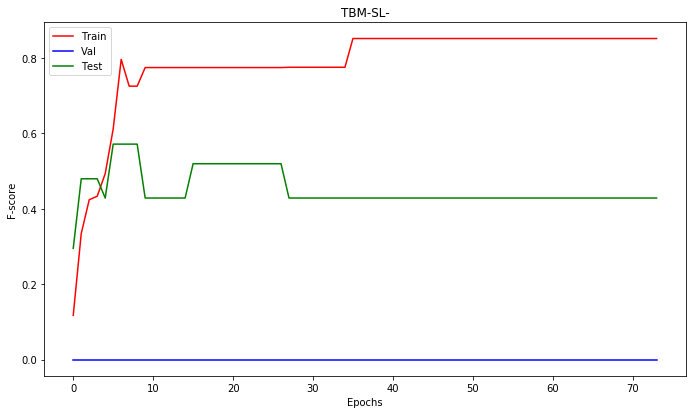

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=74=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


==========Epoch No:74==========
Training Loss: 10.224635601043701
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




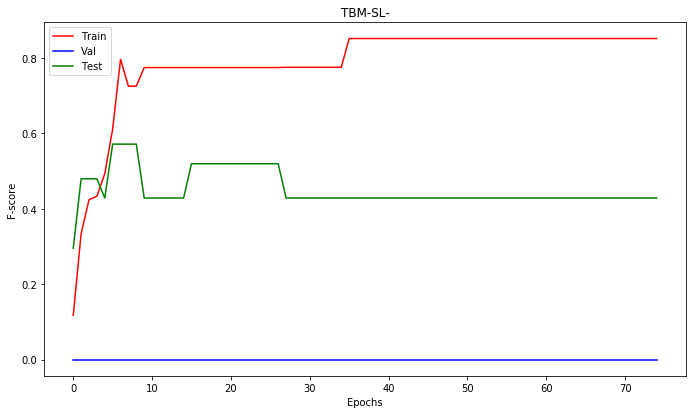

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=75=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


==========Epoch No:75==========
Training Loss: 10.163888990879059
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




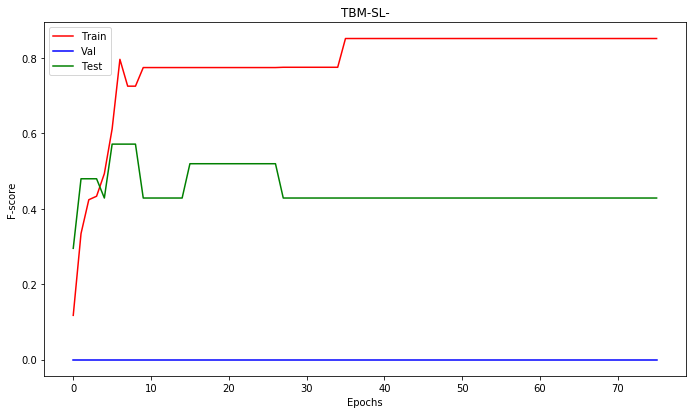

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=76=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


==========Epoch No:76==========
Training Loss: 10.099753022193909
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




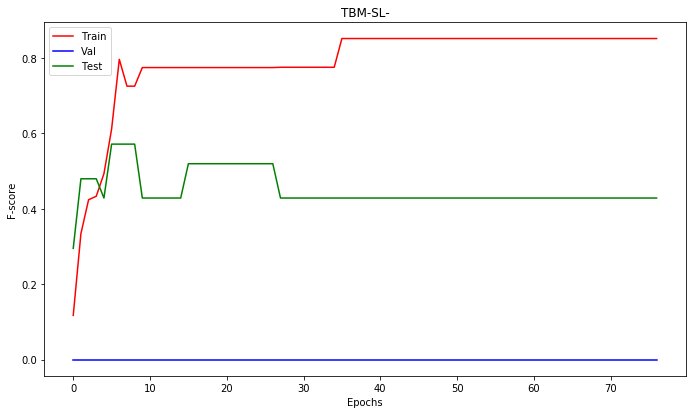

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=77=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


==========Epoch No:77==========
Training Loss: 10.033483505249023
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




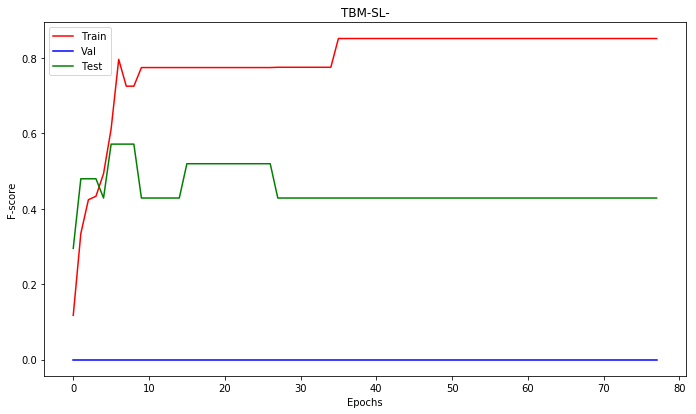

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=78=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


==========Epoch No:78==========
Training Loss: 9.969469249248505
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




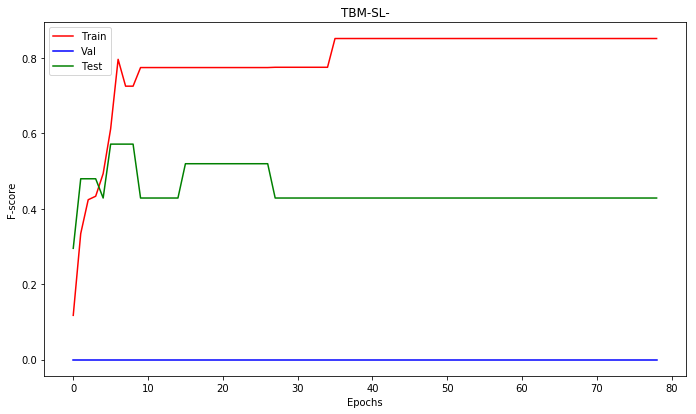

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=79=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


==========Epoch No:79==========
Training Loss: 9.892215728759766
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




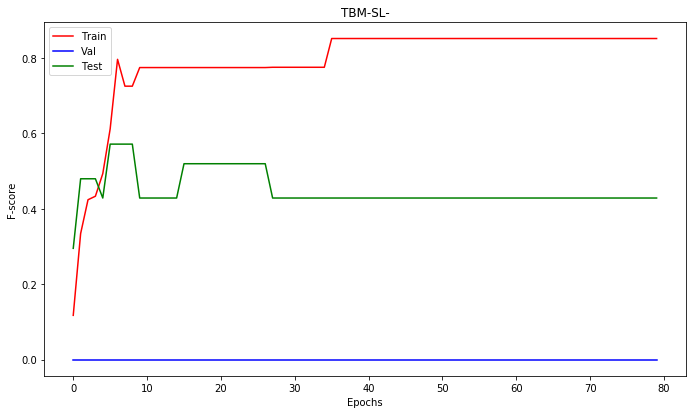

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=80=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


==========Epoch No:80==========
Training Loss: 9.830392956733704
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




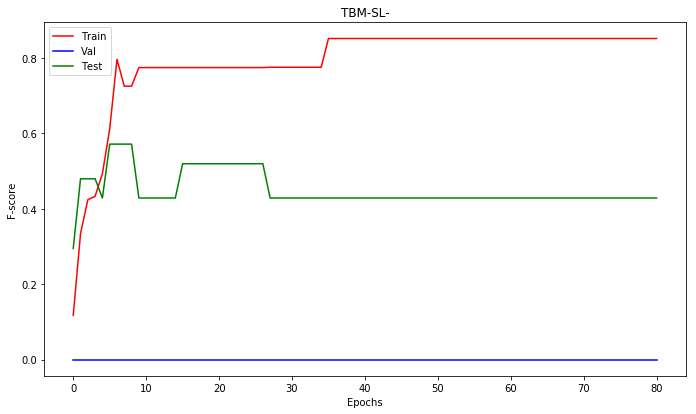

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=81=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


==========Epoch No:81==========
Training Loss: 9.77660870552063
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




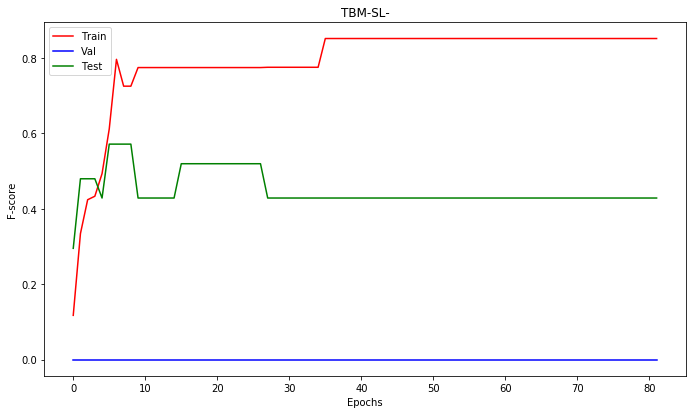

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=82=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


==========Epoch No:82==========
Training Loss: 9.723974823951721
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




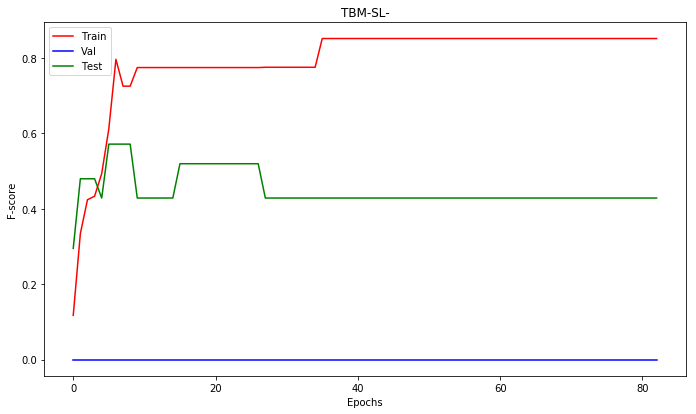

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=83=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


==========Epoch No:83==========
Training Loss: 9.672261357307434
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




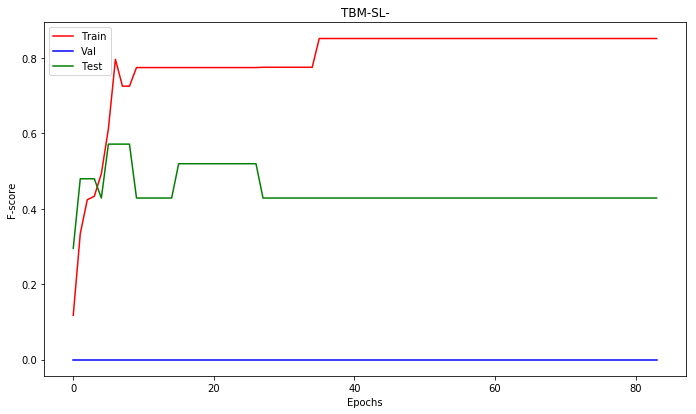

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=84=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


==========Epoch No:84==========
Training Loss: 9.621336579322815
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




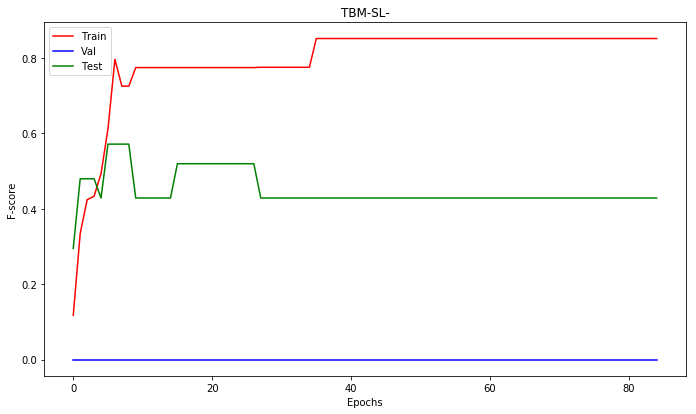

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=85=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.34it/s]


==========Epoch No:85==========
Training Loss: 9.57110846042633
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




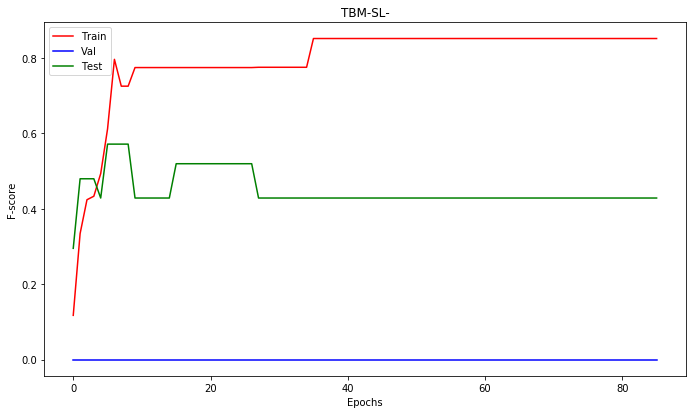

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=86=#==#==#==#==#=


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


==========Epoch No:86==========
Training Loss: 9.521524667739868
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




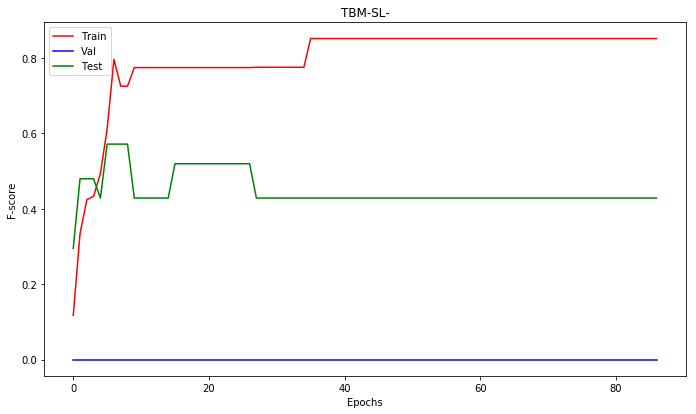

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=87=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


==========Epoch No:87==========
Training Loss: 9.472589552402496
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




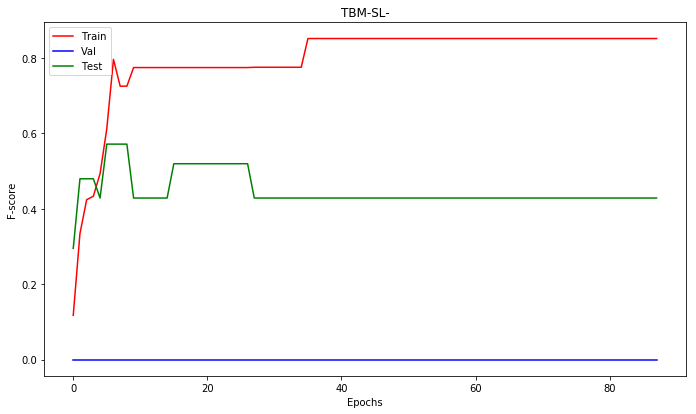

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=88=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


==========Epoch No:88==========
Training Loss: 9.42431640625
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




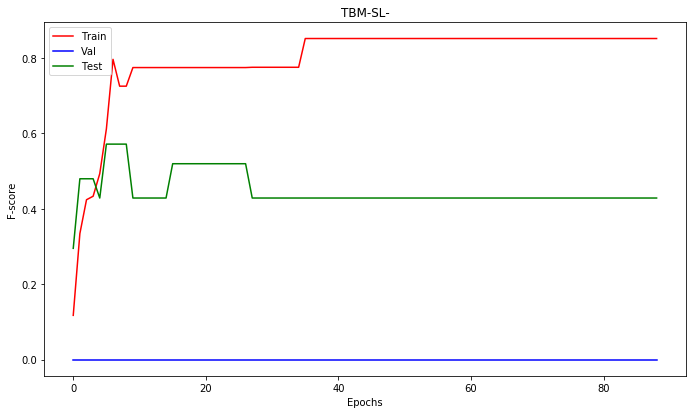

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=89=#==#==#==#==#=


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


==========Epoch No:89==========
Training Loss: 9.376649737358093
Train: (0.8392857142857143, 0.8823529411764706, 0.8512820512820513, None)
                  0         1         2    3    4
Precision  1.000000  0.857143  0.875000  0.0  0.0
Recall     0.666667  1.000000  1.000000  0.0  0.0
F-score    0.800000  0.923077  0.933333  0.0  0.0
Count      3.000000  6.000000  7.000000  0.0  1.0
--------
Val: (0.0, 0.0, 0.0, None)
             0    1    2    3    4
Precision  0.0  0.0  0.0  0.0  0.0
Recall     0.0  0.0  0.0  0.0  0.0
F-score    0.0  0.0  0.0  0.0  0.0
Count      0.0  1.0  2.0  2.0  0.0
--------
Test: (0.42857142857142855, 0.42857142857142855, 0.42857142857142855, None)
             0    1    2    3    4
Precision  0.0  0.0  0.6  0.0  0.0
Recall     0.0  0.0  0.6  0.0  0.0
F-score    0.0  0.0  0.6  0.0  0.0
Count      1.0  0.0  5.0  1.0  0.0




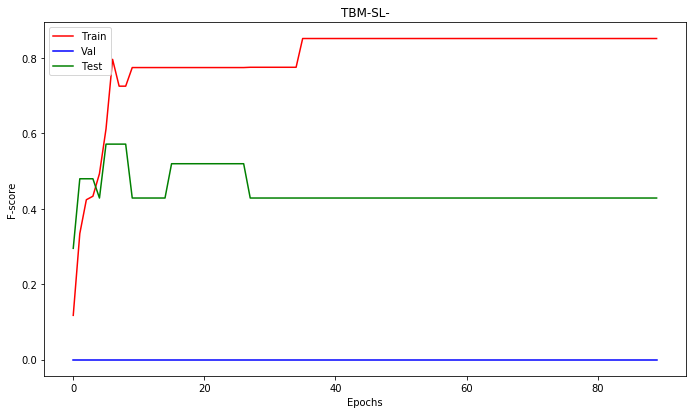

In [11]:
start_epoch = 0
end_epoch = 90
model_name = params['model_name']
target_classes = [0,1,2,3,4]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("DEVICE: {}".format(device))
loss_track = []
for iter_ in range(start_epoch, end_epoch):
    print ("=#="*5+str(iter_)+"=#="*5)
    total_loss = 0
    preds_train = []
    actual_train = []
    for each_ID in tqdm(data['train_ids']):
        model_RNN.zero_grad()
        tag_scores = model_RNN(data['data'], each_ID)
        
        _, ind_ = torch.max(tag_scores, dim=1)
        preds_train+=ind_.tolist()
        
        curr_labels = [data['data'][each_ID][-1]]
        actual_train+=curr_labels
        curr_labels = torch.LongTensor(curr_labels).cuda().to(device)
        curr_labels = autograd.Variable(curr_labels)
        
        loss = loss_function(tag_scores, curr_labels.reshape(tag_scores.shape[0]))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
    loss_track.append(total_loss)
    df_tr = pd.DataFrame(list(precision_recall_fscore_support(actual_train, preds_train, labels = target_classes)),
                       columns = list(range(len(target_classes))))
    df_tr.index = ['Precision','Recall','F-score','Count']
    prf_tr = precision_recall_fscore_support(actual_train, preds_train, average='weighted')
    prf_test, df_test = eval_plot.evaluate_dbm(model_RNN, data, 'test_ids', target_n=target_classes)

    prf_val, df_val = eval_plot.evaluate_dbm(model_RNN, data, 'val_ids', target_n=target_classes)
    
    df_all = pd.concat([df_tr, df_val, df_test],axis=1)
    dict_df_prf_mod['Epoch'+str(iter_)] = df_all
    
    print('=='*5 + "Epoch No:"+str(iter_) +"=="*5)
    print("Training Loss: "+str(total_loss))
    print("=="*4)
    print("Train: " + str(prf_tr))
    print(df_tr)
    print("--"*4)
    print("Val: " + str(prf_val))
    print(df_val)
    print("--"*4)
    print("Test: " + str(prf_test))
    print(df_test)
    print('=='*40)
    print('\n')

    eval_plot.plot_graphs(dict_df_prf_mod, 'F-score', 
                  model_path + "/" +model_name+str(iter_)+'.png',
                  0, iter_+1, 
                  model_name, target_n=len(target_classes))

#     if(save_flag):
#         torch.save(model_RNN, '../../Models/'+model_name+str(iter_)+'.pt')
#         pickle.dump(dict_df_prf_mod, open('../../Results/dict_prf_'+model_name+str(iter_)+'.pkl','wb'))
#         eval_plot.plot_graphs(dict_df_prf_mod, 'F-score', 
#                               '../../Plots/'+model_name+str(iter_)+'.png',
#                               0, iter_+1, 
#                               model_name)

In [12]:
print(loss_track)

[27.569310784339905, 25.88862442970276, 24.871376514434814, 23.955513954162598, 23.25163507461548, 22.413680493831635, 21.626911163330078, 21.113948106765747, 20.662785410881042, 20.19420349597931, 19.76724022626877, 19.36943870782852, 18.888858020305634, 18.439510583877563, 18.17592054605484, 17.784065186977386, 17.454504549503326, 17.17171961069107, 16.886906325817108, 16.588232100009918, 16.355861127376556, 16.13964545726776, 15.932045698165894, 15.726922929286957, 15.460174858570099, 15.266480207443237, 15.07531875371933, 14.782490253448486, 14.58067125082016, 14.392228484153748, 14.222464978694916, 14.058341801166534, 13.896140813827515, 13.744601905345917, 13.593808233737946, 13.444940865039825, 13.285640060901642, 13.130046248435974, 12.989056169986725, 12.859531998634338, 12.737722277641296, 12.620981097221375, 12.507697820663452, 12.396816492080688, 12.270698487758636, 12.15279096364975, 12.048622727394104, 11.946211576461792, 12.21781837940216, 12.098135948181152, 11.99058717

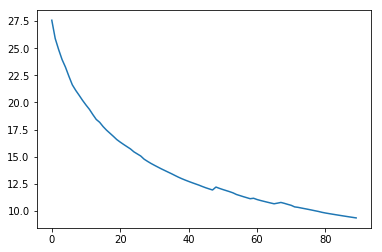

In [13]:
plt.plot(list(range(len(loss_track))), loss_track)